##  Modeling the Impact of Stomatal Resistance Parameterizations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of different stomatal resistance parameterizations on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at three different stomatal resistance parameterizations: the simple soil resistance method, the Ball Berry method, and the Jarvis method.

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the three different stomatal resistance parameterizations are described. Next, the Methods section describes how the pySUMMA can be used to create three different versions of the Reynolds Mountain East catchment model, one for each stomatal resistance parameterization. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 7 from Clark et al. (2015). 

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

## 2. Background

### The stomatal resistance parameterizations available in SUMMA

In [ ]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

### 1.) The simple soil resistance method

\begin{equation*}
r_{{s},{sun}} = r_{{s},{shd}} = \frac{r_{0c}}{\beta_v} \,\,\,\, 
\end{equation*}
$r_{0c} \,(s\,m^{-1})$ : the minimum stomatal resistance ,     ${\beta_v}\,(-)$ : the total soil water stress function

\begin{equation*}
{\beta_v} = \sum f_{{roots},{j}} \beta_{{v},{j}}  +  f_{roots}^{aq} \beta_{v}^{aq}
\end{equation*}
$z_{soil}$ : the soil depth, $f_{{roots},{j}}$ : the root density in the $j$-th soil layer
$\beta_{{v},{j}}$ : the water availability stress funtion in the $j$-th soil layer <br/>
$f_{roots}^{aq}$ : the fraction of roots for the aquifer, $\beta_{v}^{aq}$ : water availability stress function for the aquifer

For additional detail, see: https://github.com/DavidChoi76/pysumma/blob/master/simple1.png

### 2.) The Ball-Berry method
 

\begin{equation*}
g_i = v_t  \frac{A_i}{c_{air}}\frac{e_{air}}{e_{sat}(T_{veg})}P_{air} + g_{min}\beta_v, \,\,\,\,   i = sun, shd
\end{equation*}

$g_i\, (micromol \,\, m^{-2} s^{-1})$ : Stomatal conductance per unit sunlit and shaded leaf area <br/> 
$A_i\, (micromol \,\, m^{-2} s^{-1})$ : a function of the rate of photosynthesis <br/>
$c_{air}\, (Pa)$ : $CO_2$ concentration at the leaf surface (time varying model forcing, representing carbon fertilization) <br/>
$g_{min}\, (micromol \,\, m^{-2} s^{-1})$ : the minimum stomatal conductance <br/>
$v_t\,(-)$ : an empirical parameter to relate transpiration to the $CO_2$ flux, where a greater value of $v_t$ means the leaf consumes more water to produce the same carbon mass <br/>

For additinoal detail, see: https://github.com/DavidChoi76/pysumma/blob/master/BallBerry.png

### 3) The Jarvis method

\begin{equation*}
r_{{s},{i}} = \frac{r_{0c}}{f(Q_{{PAR},{i}})f(T_{air})f(e_{d})\beta_v} \,\,\,\,   i = sun, shd
\end{equation*}

the subscript $i$ defines either sunlit or shaded leaves <br/> 
$f(Q_{{PAR},{i}})$, $f(T_{air})$, $f(e_{d})$ : all limited to the range 0-1, represent the effects of photosynthetically-active radiation(PAR), air temperature, and vapor pressure deficit, where $ Q_{{PAR},{i}} $ represents PAR absorbed on sunlit or shaded leaves <br/> 

For additional detail, see: https://github.com/DavidChoi76/pysumma/blob/master/Jarvis.png

The above images are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [ ]:
from ipyleaflet import Map, GeoJSON
import json

In [ ]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

### 2) Create pySUMMA Simulation Object

In [2]:
from pysumma.Simulation import Simulation

In [3]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S = Simulation('../../summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt')

In [4]:
# set the simulation start and finish times
S.decision_obj.simulStart.value = "2007-07-01 00:00"
S.decision_obj.simulFinsh.value = "2007-08-20 00:00"

### 3) Run SUMMA for the different stomatal resistance parameterization options with Developing version of Docker image

In [5]:
# query for the available stomatal resistance parameterizations
S.decision_obj.stomResist.options

['BallBerry', 'Jarvis', 'simpleResistance']

#### 3.4) assign the Jarvis method 

In [6]:
S.decision_obj.stomResist.value = 'Jarvis'
S.decision_obj.stomResist.value

'Jarvis'

In [7]:
results_Jarvis, output_path = S.execute(run_suffix="Jarvis_docker", run_option = 'docker')

## 4. Results

### Recreate the Figure 7 plot from Clark et al., 2015: The total ET for the three different stomatal resistance methods

In [8]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
jtplot.figsize(x=10, y=10)

#### 4.1) Create P attribute using Plotting.py and output_path

In [9]:
# create P attribute 
P = Plotting(output_path)
# create Plot attribute with open_netcdf method
Plot = P.open_netcdf()

#### 4.2) Explain output variables

#### There are three structure types of variables 

1) variable (time, hru or gru) : [example] pptrate, airtemp, basin__SurfaceRunoff,  ...

2) variable (time, midToto, hru) : [example] mLayerVolFracIce, mLayerVolFracLiq, mLayerVolFracWat, ... 

 - 'mid' are associated with variables that are specified at the mid-point of each layer (or layer-average)
 - 'Toto indicate snow layers, soil layers, and all layers,

3) variable (time, midSoil, hru) : [example] mLayerMatricHead, mLayerLiqFluxSoil 

4) variable (time, ifcToto, hru) : [example] iLayerHeight 
 - 'ifc' are associated with variables that are specified at the interfaces between layers including the very top and bottom
 
5) variable (time, ifcSoil, hru) : [example] iLayerLiqFluxSoil 

In [10]:
# explain output variables
Plot

<xarray.Dataset>
Dimensions:                    (gru: 1, hru: 1, ifcSoil: 9, ifcToto: 14, midSoil: 8, midToto: 13, time: 1201)
Coordinates:
  * time                       (time) datetime64[ns] 2007-07-01 ...
  * hru                        (hru) int32 1
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    hruId                      (hru) int32 ...
    basin__SurfaceRunoff       (time, gru) float64 ...
    basin__ColumnOutflow       (time, gru) float64 ...
    basin__AquiferStorage      (time, gru) float64 ...
    basin__AquiferRecharge     (time, gru) float64 ...
    basin__AquiferBaseflow     (time, gru) float64 ...
    basin__AquiferTranspire    (time, gru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    nSnow                      (time, hru) int32 ...
    nSoil

#### 4.3) Plot (variable)

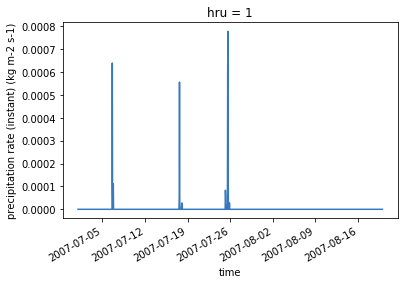

In [14]:
# The case of "1) variable (time, hru or gru)"
P.plot_1d('pptrate')

#### 4.4) Plot hru (hru_num, variable)

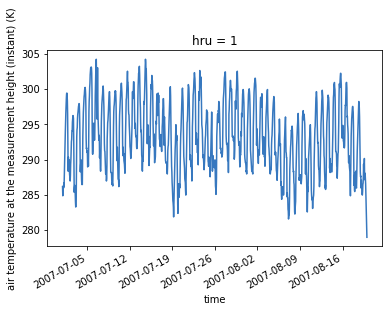

In [15]:
# The case of "1) variable (time, hru or gru) and more than 2 hru
P.plot_1d_hru(0,'airtemp')

#### 4.5) Plot layer (variable)

In [16]:
# the case of 2) variable (time, midToto, hru) : [example] mLayerVolFracIce, mLayerVolFracLiq, mLayerVolFracWat, ... 
# midToto: 13
test = Plot['mLayerVolFracWat'].data
dates = Plot['time'].data
# convert data array
test = np.squeeze(test)
# create df attribute using pandas DataFrame    
df = pd.DataFrame(data = test, index=dates)
df.replace(to_replace=-9999.0, value = 0, inplace=True)

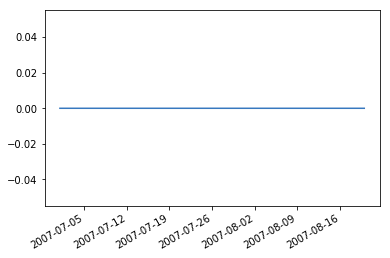

In [17]:
# midToto is 13, therefore user can change each layer value from 0 to 12
df[12].plot()

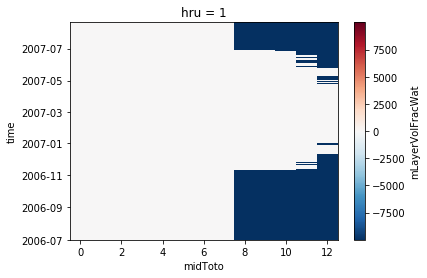

In [15]:
P.plot_1d_layer('mLayerVolFracWat')

In [16]:
# the case of 3) variable (time, midSoil, hru) : [example] mLayerMatricHead, mLayerLiqFluxSoil 
# midSoil: 8
test = Plot['mLayerLiqFluxSoil'].data
dates = Plot['time'].data
# convert data array
test = np.squeeze(test)
# create df attribute using pandas DataFrame    
df = pd.DataFrame(data = test, index=dates)
df.replace(to_replace=-9999.0, value = 0, inplace=True)

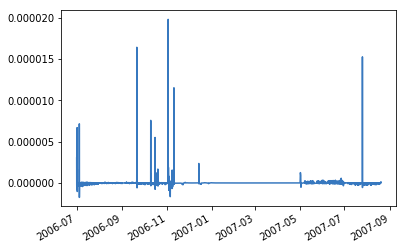

In [19]:
# midToto is 13, therefore user can change each layer value from 0 to 12
df[0].plot()

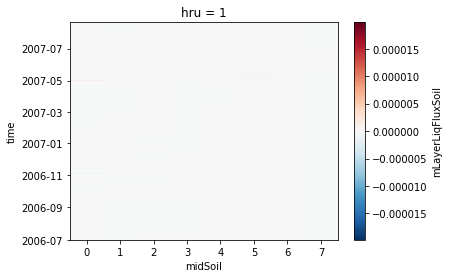

In [20]:
P.plot_1d_layer('mLayerLiqFluxSoil')

In [21]:
# the case of 4) variable (time, ifcToto, hru) : [example] iLayerHeight
# midSoil: 14
test = Plot['iLayerHeight'].data
dates = Plot['time'].data
# convert data array
test = np.squeeze(test)
# create df attribute using pandas DataFrame    
df = pd.DataFrame(data = test, index=dates)
df.replace(to_replace=-9999.0, value = 0, inplace=True)

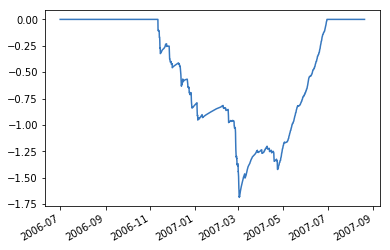

In [22]:
# midToto is 13, therefore user can change each layer value from 0 to 12
df[0].plot()

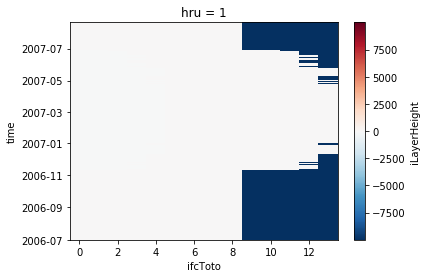

In [23]:
P.plot_1d_layer('iLayerHeight')

In [24]:
# the case of 5) variable (time, ifcSoil, hru) : [example] iLayerLiqFluxSoil
# midSoil: 9
test = Plot['iLayerLiqFluxSoil'].data
dates = Plot['time'].data
# convert data array
test = np.squeeze(test)
# create df attribute using pandas DataFrame    
df = pd.DataFrame(data = test, index=dates)
df.replace(to_replace=-9999.0, value = 0, inplace=True)

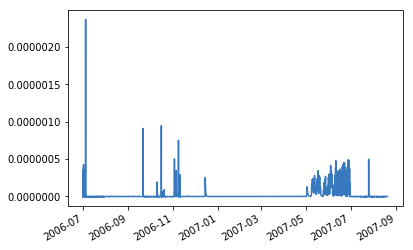

In [25]:
# midToto is 13, therefore user can change each layer value from 0 to 12
df[0].plot()

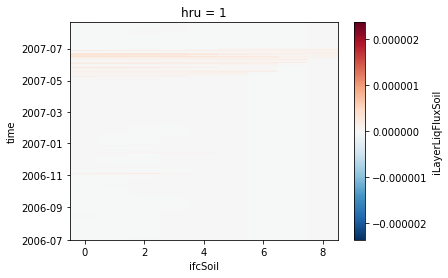

In [26]:
P.plot_1d_layer('iLayerLiqFluxSoil')

In [19]:
ds = xr.open_dataset(output_path).isel(hru=0)

In [20]:
from pysumma.layers import layers

In [23]:
layers(ds.isel(time=slice(0,50)), 'iLayerHeight')

ValueError: Dataset provided doesn't appear to have layers!